In [1]:
#librabry
import requests
import math
import matplotlib.pyplot as plt
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path

import os
from os import listdir
from os.path import isfile, join
from xml.dom import minidom

import torch
import torch.nn as nn
from sklearn.metrics import classification_report
from collections import defaultdict
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup, AutoModel, BertTokenizerFast, BertModel, BertTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import matplotlib.pyplot as plt

import urllib.request
import requests
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.decomposition import PCA

d:\GitHubFile\Final-NLP\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Specifying GPU
device = torch.device ('cuda')

In [3]:
#Training dataset
path = 'D:/GitHubFile/Final-NLP/data/train'
with open(path+'/en.txt') as f:
    lines = f.readlines()

In [4]:
id2gender_train = {}
for item in lines:
    n = 0
    l = len (item)
    if item[-7] == 'f':
        v = 'F'
        n = -10
    else:
        v = 'M'
        n = -8
    k = item[:n]
    id2gender_train[k] = v


In [5]:
id2texts_train = {}
path1 = path + '/text/'
for k in id2gender_train.keys():
  file = minidom.parse (path1 + k + '.xml')
  docs = file.getElementsByTagName ('document')
  l = len (docs)
  aux = [docs[i].childNodes[0].data for i in range (0, l)]
  id2texts_train[k] = aux

In [6]:
ids = [k for k in list(id2texts_train.keys()) for i in range (0, len(id2texts_train[k]))]
texts = []
for k in list(id2texts_train.keys()):
  for t in id2texts_train[k]:
    # Cleaning
    t = re.sub ('\S+@\S+', ' ', t)
    t = re.sub ('@\S+', ' ', t)
    t = re.sub ('http\S+', ' ', t)
    t = t.replace ('....', '.')
    t = t.replace ('...', '.')
    t = t.replace ('..', '.')
    t = t.replace ('   ', ' ')
    t = t.replace ('  ', ' ')
    t = t.replace (',,,,', ',')
    t = t.replace (',,,', ',')
    t = t.replace (',,', ',')
    if t[0] == ' ':
      t = t[1:]
    s = len (t)
    if s != 0 and t[s-1] == ' ':
      t = t[:s-1]
    texts.append (t)
df = pd.DataFrame (data={'ids':ids, 'texts':texts})
df.to_csv ('D:/GitHubFile/Final-NLP/train_texts.csv', index=False)

In [7]:
#Testing dataset
path = 'D:/GitHubFile/Final-NLP/data/test'
with open(path+'/en.txt') as f:
    lines = f.readlines()

In [8]:
id2gender_test = {}
for item in lines:
  n = 0
  l = len (item)
  if item[-7] == 'f':
    v = 'F'
    n = -10
  else:
    v = 'M'
    n = -8
  k = item[:n]
  id2gender_test[k] = v

In [9]:
id2texts_test = {}
path1 = path + '/text/'
for k in id2gender_test.keys():
  file = minidom.parse (path1 + k + '.xml')
  docs = file.getElementsByTagName ('document')
  l = len (docs)
  aux = [docs[i].childNodes[0].data for i in range (0, l)]
  id2texts_test[k] = aux

In [10]:
ids = [k for k in list(id2texts_test.keys()) for i in range (0, len(id2texts_test[k]))]
texts = []
for k in list(id2texts_test.keys()):
  for t in id2texts_test[k]:
    # Cleaning
    t = re.sub ('\S+@\S+', ' ', t)
    t = re.sub ('@\S+', ' ', t)
    t = re.sub ('http\S+', ' ', t)
    t = t.replace ('....', '.')
    t = t.replace ('...', '.')
    t = t.replace ('..', '.')
    t = t.replace ('   ', ' ')
    t = t.replace ('  ', ' ')
    t = t.replace (',,,,', ',')
    t = t.replace (',,,', ',')
    t = t.replace (',,', ',')
    if t[0] == ' ':
      t = t[1:]
    s = len (t)
    if s != 0 and t[s-1] == ' ':
      t = t[:s-1]
    texts.append (t)
df = pd.DataFrame (data={'ids':ids, 'texts':texts})
df.to_csv ('D:/GitHubFile/Final-NLP/test_texts.csv', index=False)

In [11]:
train_texts = pd.read_csv ('D:/GitHubFile/Final-NLP/train_texts.csv')
test_texts = pd.read_csv ('D:/GitHubFile/Final-NLP/test_texts.csv')

In [34]:
bert = BertModel.from_pretrained ('bert-base-cased')
tokenizer = BertTokenizer.from_pretrained ('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
ids = pd.unique(train_texts['ids']).tolist()
id2texts_train = {}
for i in ids:
  id2texts_train[i] = []
  df1 = train_texts[train_texts['ids'] == i]
  for j in range (0, 10):
    id2texts_train[i].append (' '.join (list(df1['texts'].astype(str))[10*j:10*(j+1)]))

In [14]:
ids = pd.unique(test_texts['ids']).tolist()
id2texts_test = {}
for i in ids:
  id2texts_test[i] = []
  df1 = test_texts[test_texts['ids'] == i]
  for j in range (0, 10):
    id2texts_test[i].append (' '.join (list(df1['texts'].astype(str))[10*j:10*(j+1)]))

In [17]:
max_len = 256

In [18]:
id2tokens_train = {}
for k in list(id2texts_train.keys()):
  tokens = tokenizer.batch_encode_plus (id2texts_train[k], max_length=max_len, pad_to_max_length=True, add_special_tokens=True, truncation=True)
  id2tokens_train[k] = tokens

d:\GitHubFile\Final-NLP\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:
id2tokens_test = {}
for k in list(id2texts_test.keys()):
  tokens = tokenizer.batch_encode_plus (id2texts_test[k], max_length=max_len, pad_to_max_length=True, add_special_tokens=True, truncation=True)
  id2tokens_test[k] = tokens

In [20]:
# Convert lists to tensors
ids = [x for x in range(0, len(id2tokens_train)) for i in range(0, 10)]
ids = torch.tensor (ids)
train_seq = [x for k in list(id2tokens_train.keys()) for x in id2tokens_train[k]['input_ids']]
train_seq = torch.tensor (train_seq)
train_mask = [x for k in list(id2tokens_train.keys()) for x in id2tokens_train[k]['attention_mask']]
train_mask = torch.tensor (train_mask)
train_y = [0 if id2gender_train[k] == 'F' else 1 for k in list(id2tokens_train.keys()) for i in range(0, 10)]
train_y = torch.tensor (train_y)

In [21]:
ids2 = [x for x in range(0, len(id2tokens_test)) for i in range(0, 10)]
ids2 = torch.tensor (ids2)
test_seq = [x for k in list(id2tokens_test.keys()) for x in id2tokens_test[k]['input_ids']]
test_seq = torch.tensor (test_seq)
test_mask = [x for k in list(id2tokens_test.keys()) for x in id2tokens_test[k]['attention_mask']]
test_mask = torch.tensor (test_mask)
test_y = [0 if id2gender_test[k] == 'F' else 1 for k in list(id2tokens_test.keys()) for i in range(0, 10)]
test_y = torch.tensor (test_y)

In [22]:
batch_size = 32

In [25]:
classes = 2

In [32]:
class BertGenderClassifier (nn.Module):
  def __init__ (self, bert, classes):
    super (BertGenderClassifier, self).__init__()

    self.bert = bert
    self.dropout = nn.Dropout (p=0.1)
    self.out = nn.Linear (self.bert.config.hidden_size, classes)

  def forward (self, input_ids, attention_mask):
    _, bert_output = self.bert (input_ids=input_ids, 
                                attention_mask=attention_mask, return_dict=False)
    #print (bert_output)
    output = self.dropout (bert_output)
    
    return self.out (output)

<BarContainer object of 2 artists>

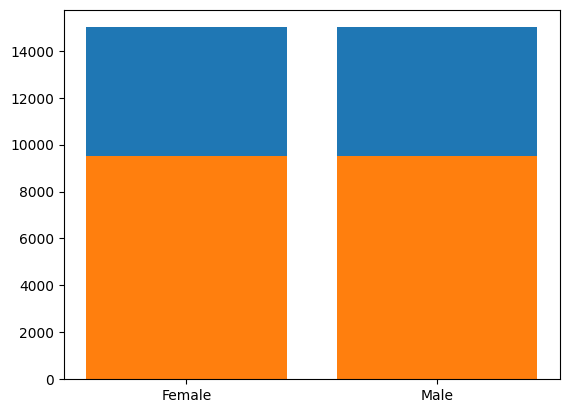

In [33]:
# Create an instance of our model and push it to GPU
model = BertGenderClassifier (bert, classes)
model = model.to (device)

plt.bar (['Female', 'Male'], [train_y.tolist().count(0), train_y.tolist().count(1)])

plt.bar (['Female', 'Male'], [test_y.tolist().count(0), test_y.tolist().count(1)])

In [28]:
epochs = 8 #20

optimizer = AdamW (model.parameters(), lr=2e-5)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup (optimizer, num_warmup_steps=0, num_training_steps=total_steps)

ce_loss = nn.CrossEntropyLoss().to (device)

d:\GitHubFile\Final-NLP\.venv\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
